## Week 3 Video Notebook -- The Bias-Variance Tradeoff, Underfitting, and Overfitting



### Part One:  Understanding Bias and Variance in ML Models

The primary goal in machine learning is to build models from an existing dataset which generalize well to new, unseen data from the same domain. Precisely, we want to minimize the MSE for predictions on a data that the model was not trained on, and we want to understand the sources of this error. 

**Bias** refers to systematic error in the model’s assumptions. A simple or overly constrained model may not be flexible enough to capture the true relationship between features and target variable. Such a model will consistently miss-estimate the true value, leading to high bias. Such a model is said to **underfit** the data. 

**Variance** measures how much the model’s predictions change when it is trained on different subsets of the data. A highly flexible model can fit the training data very closely—potentially even capturing noise or irrelevant patterns. While this can reduce bias (the model can represent complex relationships), it makes the model highly sensitive to small changes in the training data, thus increasing variance. Such a model is said be **overfit** the data. 

The formula on p.32 of the textbook decomposes the test MSE into reducible errors (due to the bias and variance of the model) and irreducible errors (due to noise in the data): 

$$
\mathbb{E}\left[(y_0 - \hat{f}(x_0))^2\right] 
      = \underbrace{\underbrace{\big(f(x_0) - \mathbb{E}[\hat{f}(x_0)]\big)^2}_{\text{Bias}^2} 
      + \underbrace{\text{Var}(\hat{f}(x_0))}_{\text{Variance}}}_{\text{Reducible Error}}
      + \underbrace{\text{Var}(\epsilon)}_{\text{Irreducible Error}}
$$

This notebook will provide motivation and understanding of this formula. 

For a full derivation, see Appendix A at the bottom of this notebook. 


#### Creating a Synthetic Dataset with Noise

In order to analyze this rigorously, we assume we have a perfect function $f$ generating our data and a source of errors ("noise") $\epsilon$ such that the mean $\mathbb{E}(\epsilon)$ is 0. Therefore there is a potentially infinite dataset

$$\mathbb{D}\ =\ \{\ (x,y)\ |\ y=f(x)+\epsilon\ \},$$

Any particular dataset $(X,Y)$ is a finite random sample from this domain:

$$(X,Y)\subseteq \mathbb{D}.$$

In this video, we will assume our "perfect model" is a cubic polynomial

$$y\ =\ 0.125x^3 - 1.2x^2 + 3x + 0.5$$

and the errors are normally distributed with mean 0 and standard deviation `stdev` which we can change. 

Let's take a look at what the dataset looks like....

In [1]:
# necessary imports

import numpy as np
from numpy import arange,linspace,mean, var, std
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from numpy.random import random, normal 
from numpy.linalg import inv
import math
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

lb = 0
ub = 7

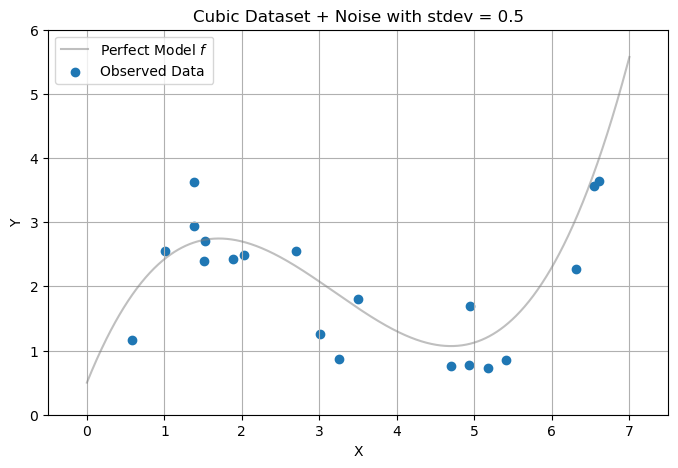

In [2]:
# Our idealized data generating function f:

def f(x):
    return 0.125*x**3 - 1.2*x**2 + 3*x + 0.5

lb = 0
ub = 7

def show_dataset(size,error_std,show_model):
    
    X_all = np.linspace(lb,ub,1000)
    Y_perfect_model = f(X_all)


    # dataset
    X = np.sort(np.random.uniform(low=lb, high=ub, size=size))
    Y = f(X) + np.random.normal(0, error_std,size=size)


    # Plotting the scatter plot of the data 

    plt.figure(figsize=(8, 5))

    if size <=20:
        marker = 'o'
    else:
        marker = '.'

    plt.scatter(X, Y, label='Observed Data', marker=marker)
    if show_model:
        plt.plot(X_all, Y_perfect_model, label='Perfect Model $f$', color='grey', alpha=0.5)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([-0.5,7.5])
    plt.ylim([0,6])
    plt.title(f'Cubic Dataset + Noise with stdev = {error_std}')
    plt.legend()
    plt.grid(True)
    plt.show()

    
show_dataset(size=20,error_std=0.5,show_model=True)

####  Illustrating the Bias and Variance of a Model $\hat{f}$


Now we choose a type of model $\hat{f}$ and a choice of hyperparameters (such as the degree of the polynomial), and train it on many different datasets $(X_1,Y_1), \ldots, (X_p,Y_p),$
resulting in models $\hat{f}_1,\ldots,\hat{f}_p$. 

We'd like to understand how good $\hat{f}$ is, namely, How well does it approximate $f$ given all the different training sets we might employ?  Of course, the bigger the dataset, the better the approximation will be (an immutable law of statistics!), but the point is: how good is this model at learning the characteristics of the ideal model from the data we have? Is it too simple, not even learning the basic shape of the ideal function  $f$, or is it too complicated, trying to account for the meaningly errors, again not learning $f$? Ideally, it should approximate the ideal function reasonably well for any training set, with the approximation getting better the more data that it can see. 

The Bias-Variance equation proceeds to analyze this as follows: 
for a random data point $(x_0,y_0)\in \mathbb{D}$ which is not part of any training set, what is the MSE

$$\mathbb{E}\left[(y_0 - \hat{f}(x_0))^2\right]?$$

In this analysis, picking a single test data point $(x_0,y_0)$ allows us to
treat $\hat{f}(x_0)$ as a random variable, which returns potentially different results depending on what data set $(X_j,Y_j)$ it was trained on. 

Thus, as a **random variable,** $\hat{f}(x_0)$ is an **estimator** of $y_0=f(x_0)$, with:

$$  \text{Mean:}\quad \mathbb{E}(\hat{f}(x_0))\quad\quad\quad 
\text{Bias:}\quad\mathbb{E}(\hat{f}(x_0))-f(x_0)\quad\quad\quad 
\text{Variance:}\quad \mathbb{E}\left[\, (\,\mathbb{E}[\hat{f}(x_0)] - \hat{f}(x_0)\,)^2\,\right].$$

The bias represents the systematic error of the estimator of $y_0$. Note that there will be errors from $\epsilon$ but since $\mathbb{E}(\epsilon)=0$ they cancel out and do not affect the bias or the variance.  

Let's explore the cubic dataset first with no errors to see how various models $\hat{f}$ trained on
different datasets behave as random variables. Then we will explore the dataset with various amounts of noise.

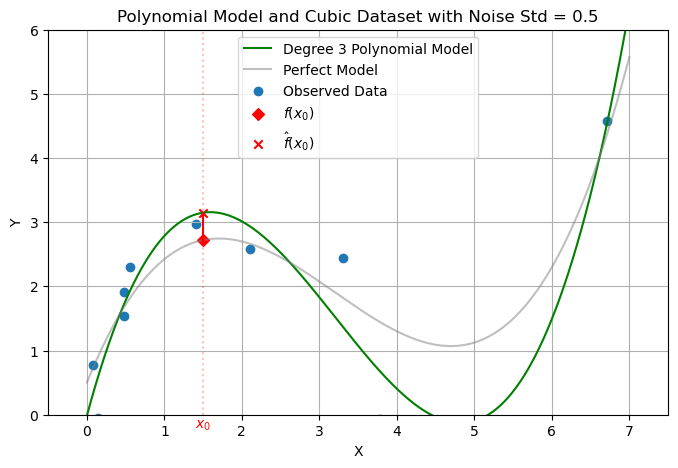

In [3]:
def show_model(size,degree,x0,error_std,show_perfect_model):
    
    lb = 0
    ub = 7

    X_all = np.linspace(lb,ub,1000)
    Y_perfect_model = f(X_all)


    y0 = f(x0)


    # dataset
    X = np.sort(np.random.uniform(low=lb, high=ub, size=size))
    Y = f(X) + np.random.normal(0, error_std,size=size)

    # Create a pipeline that first transforms the data to include polynomial features,
    # then fits a polynomial regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    # Fit the model to your data
    model.fit(X.reshape(-1,1), Y)

    Y_pred = model.predict(X.reshape(-1,1))

    # Get model points to plot

    Y_model = model.predict(X_all.reshape(-1,1))

    mse = mean_squared_error(Y,Y_pred)

    y0_pred = model.predict([[x0]])


    # Plotting the scatter plot of the data 

    plt.figure(figsize=(8, 5))

    plt.scatter(X, Y, label='Observed Data', marker='o')
    plt.plot(X_all, Y_model, label=f'Degree {degree} Polynomial Model', color='green')
    
    if show_perfect_model:
        plt.plot(X_all, Y_perfect_model, label='Perfect Model', color='grey', alpha=0.5)
        plt.scatter([x0],[y0],color='red',marker='D',label="$f(x_0)$")
        plt.plot([x0,x0],[f(x0),y0_pred[0]],color='red')
        plt.plot([x0,x0],[0,6],color='red',alpha=0.25,linestyle=':')
        plt.text(x0-0.1,-0.2,"$x_0$",color='red')
        plt.scatter([x0],[y0_pred],color='red',marker='x',label="$\hat{f}(x_0)$")

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([-0.5,7.5])
    plt.ylim([0,6])
    if error_std == 0.0:
        plt.title(f'Polynomial Model and Cubic Dataset with No Noise')
    else:
        plt.title(f'Polynomial Model and Cubic Dataset with Noise Std = {error_std}')
    plt.legend()
    plt.grid(True)
    plt.show()

#     print(f'MSE: {mse:.4f}')

show_model(size=10,degree=3,x0=1.5, error_std=0.5,show_perfect_model=True)

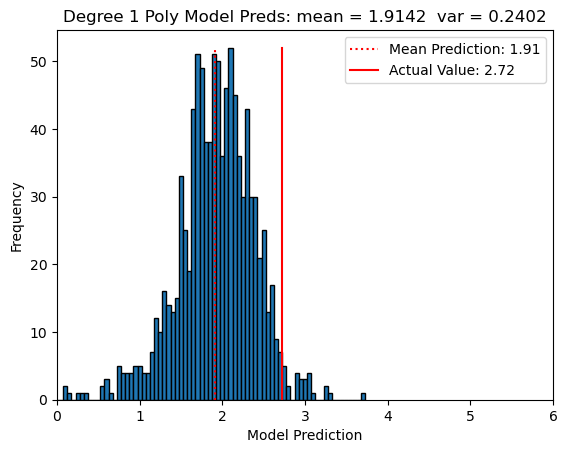

In [4]:
def plot_error_histogram(size,degree,x0,error_std,num_trials): 
    
    preds = []

    for k in range(num_trials):

        # dataset
        X = np.sort(np.random.uniform(low=lb, high=ub, size=size))
        Y = f(X) + np.random.normal(0, error_std,size=size)

        # Create a pipeline that first transforms the data to include polynomial features,
        # then fits a polynomial regression model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        # Fit the model to your data
        model.fit(X.reshape(-1,1), Y)

        y0_pred = model.predict([[x0]])

        preds.append(y0_pred[0])    
        
    
    # Determine the range for the bins
    min_val = min(preds)
    max_val = max(preds)
    
    mu = np.mean(preds)
    v = np.var(preds)
    
    # Create bins of width 0.05
    bins = np.arange(min_val, max_val + 0.05, 0.05)
    
    y0 = f(x0)
    
    # Plot the histogram
    n,_,_ = plt.hist(preds, bins=bins,edgecolor='black')
    plt.plot([mu,mu],[0,max(n)],color='red',linestyle=':',label=f"Mean Prediction: {mu:.2f}")
    plt.plot([y0,y0],[0,max(n)],color='red',label=f"Actual Value: {y0:.2f}")
    plt.xlabel('Model Prediction')
    plt.ylabel('Frequency')
    plt.xlim([0,6])
    plt.title(f'Degree {degree} Poly Model Preds: mean = {mu:.4f}  var = {v:.4f}')
    plt.legend()
    plt.show() 
    
    return (mu,v)

(mu,v) = plot_error_histogram(size=10,degree=1,x0=1.5,error_std=0.5,num_trials=1000)

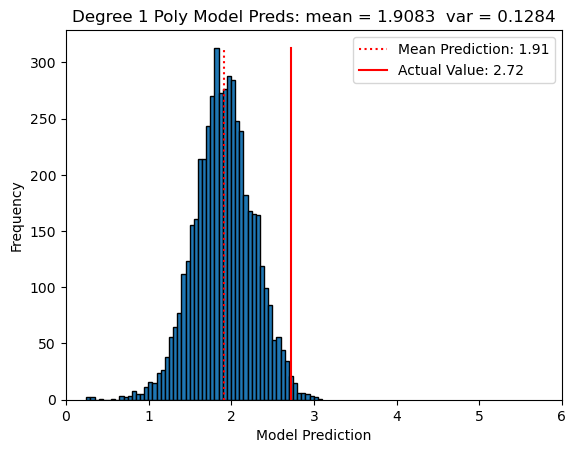

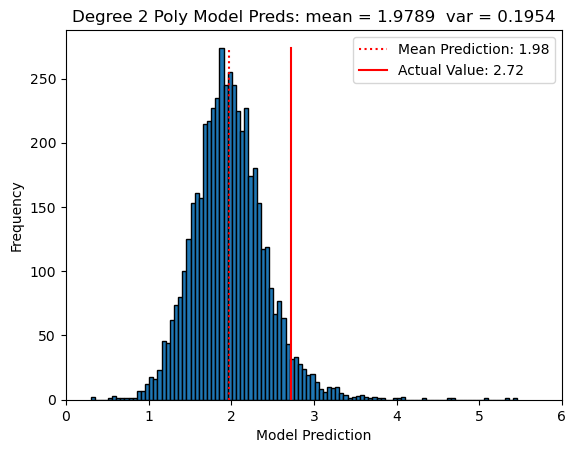

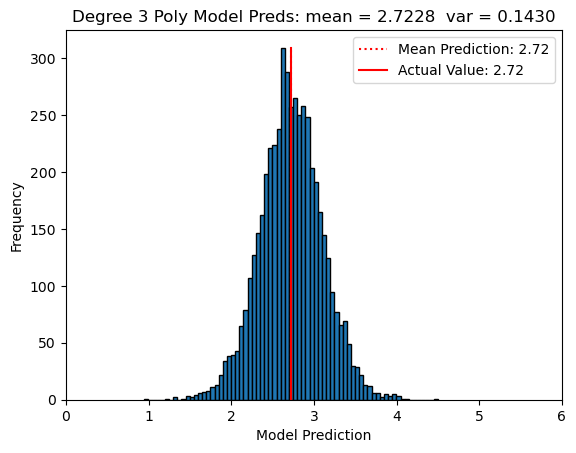

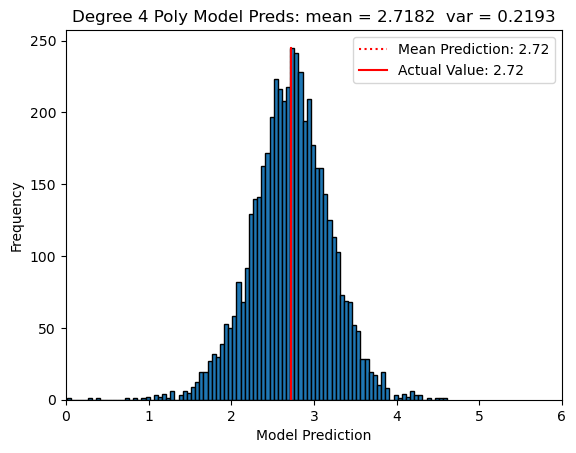

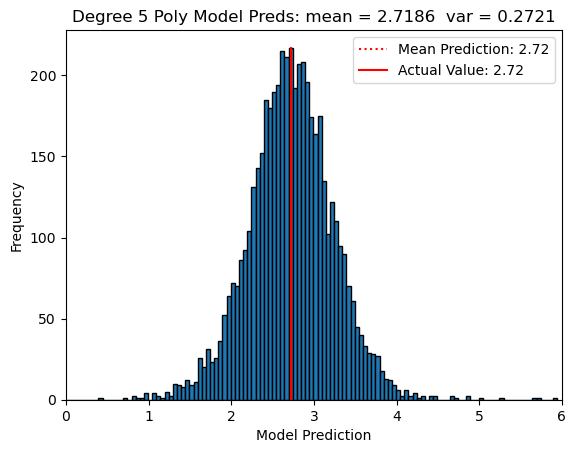

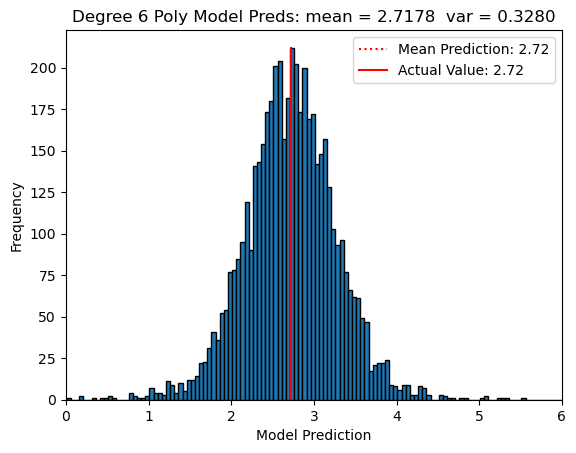

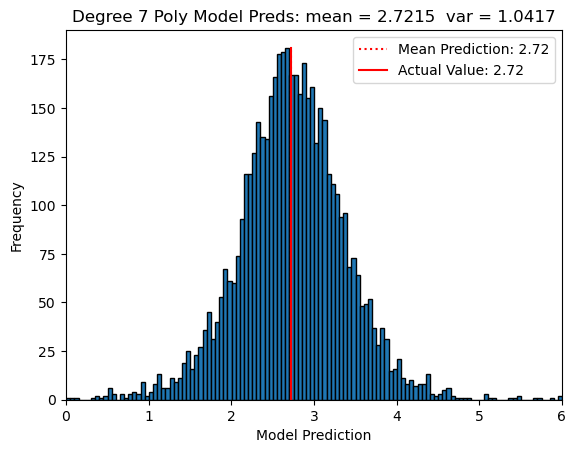

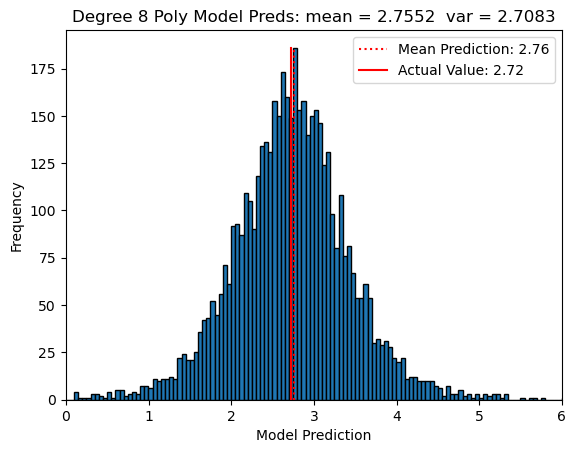

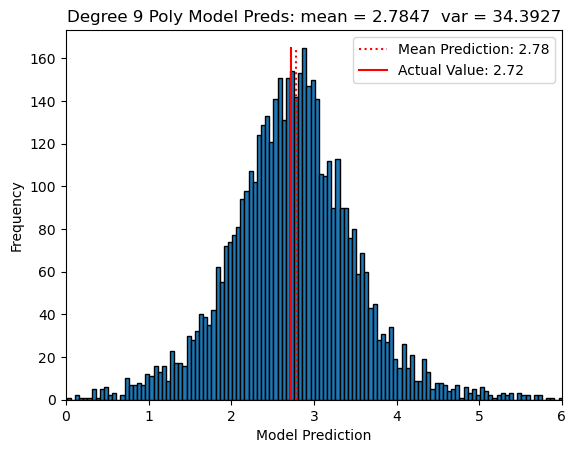

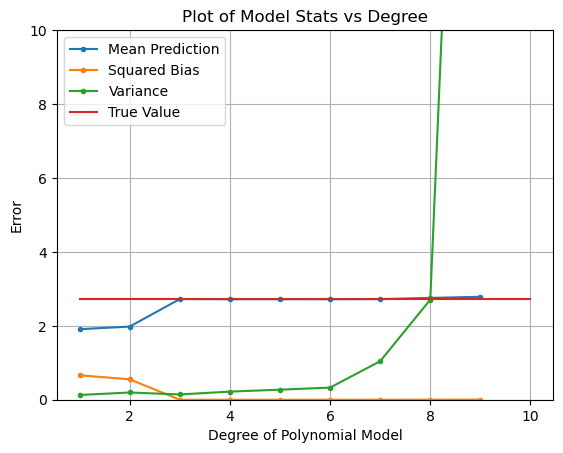

In [5]:
# Show example
    
    
mus = []
vs = []
x0 = 1.5
for d in range(1,10):
    
    (mu,v) = plot_error_histogram(size=25,degree=d,x0=1.5,error_std=1.0,num_trials=5000)
    mus.append(mu)
    vs.append(v)
    
bias2 = (np.array(mus)-f(x0))**2

plt.title("Plot of Model Stats vs Degree")   
plt.plot(range(1,10),mus,label="Mean Prediction",marker='.')
plt.plot(range(1,10),bias2,label="Squared Bias",marker='.')
plt.plot(range(1,10),vs,label="Variance",marker='.')
plt.plot([1,10],[f(x0),f(x0)],label="True Value")
plt.ylim([0,10])
plt.ylabel("Error")
plt.xlabel("Degree of Polynomial Model")
plt.legend()
plt.grid()
plt.show()

### Part Two:  The Bias-Variance Tradeoff, Underfitting, and Overfitting

If we plot the various components of the MSE using larger and larger test sets, we can see how they stabilize into the relationship shown in our formula.

$$
\mathbb{E}\left[(y_0 - \hat{f}(x_0))^2\right] 
      = \underbrace{\big(f(x_0) - \mathbb{E}[\hat{f}(x_0)]\big)^2}_{\text{Bias}^2} 
      + \underbrace{\text{Var}(\hat{f}(x_0))}_{\text{Variance}}
      + \underbrace{\text{Var}(\epsilon)}_{\text{Irreducible Error}}
$$

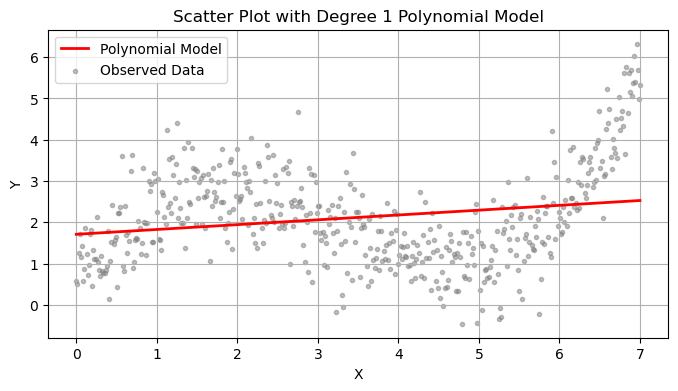

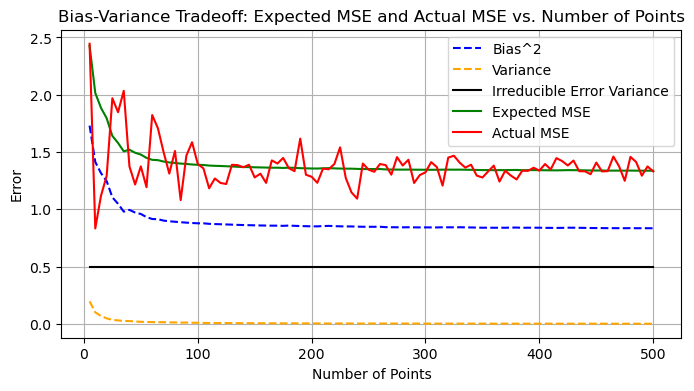

In [6]:
# Plot of various components of Bias-Variance Formula

degree=1

# Set irreducible error variance (epsilon)
irreducible_error_variance = 0.5  # Irreducible error (epsilon)
max_num_points = 500

# Function to compute bias, variance, expected MSE, and actual MSE for different number of points
def compute_mse_for_num_points():
    Y_true_full = np.linspace(lb,ub, 1000)**2  # Full dataset for true quadratic relationship
    
    # List to store values for plotting
    bias_list = []
    variance_list = []
    expected_mse_list = []
    actual_mse_list = []
    num_points_list = []

    # Iterate over different numbers of points from 5 to max_num_pointsd
    for num_points in range(5, max_num_points+1, 5):
        np.random.seed(42)
        X = np.linspace(lb, ub, num_points)
        Y_true = f(X)  # True relationship
        epsilon = np.random.normal(0, np.sqrt(irreducible_error_variance), size=X.shape)  # Irreducible error
        Y_observed = Y_true + epsilon  # Observed data with irreducible error (noise)
        
        # Fit a Linear Model
        X_reshaped = X.reshape(-1, 1)
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(X_reshaped, Y_observed)
        Y_pred = model.predict(X_reshaped)
        

        # Calculate the Squared Bias
        bias = np.mean((Y_true - Y_pred)**2)
        bias_list.append(bias)

        # Calculate the Variance
        n_samples = 100
        predictions = []

        # Generate multiple datasets with different noise
        for _ in range(n_samples):
            epsilon = np.random.normal(0, np.sqrt(irreducible_error_variance), size=X.shape)  # Different noise for each dataset
            Y_observed = Y_true + epsilon
            model.fit(X_reshaped, Y_observed)
            Y_pred = model.predict(X_reshaped)
            predictions.append(Y_pred)

        # Calculate variance of predictions
        predictions = np.array(predictions)
        variance = np.var(predictions, axis=0)
        mean_variance = np.mean(variance)
        variance_list.append(mean_variance)

        # Combine Bias, Variance, and Irreducible Error
        expected_mse = bias + mean_variance + irreducible_error_variance  # Adding irreducible error (epsilon)
        expected_mse_list.append(expected_mse)

        # Calculate the actual MSE on the current dataset
        actual_mse = mean_squared_error(Y_observed, Y_pred)
        actual_mse_list.append(actual_mse)

        # Store the number of points
        num_points_list.append(num_points)

        # If we are at 500 points, store X, Y_observed, and Y_pred for plotting
        if num_points == 500:
            X_final = X
            Y_observed_final = Y_observed
            Y_pred_final = Y_pred

    return num_points_list, bias_list, variance_list, expected_mse_list, actual_mse_list, X_final, Y_observed_final, Y_pred_final

# Generate the data and get final plot data for 500 points
num_points_list, bias_list, variance_list, expected_mse_list, actual_mse_list, X_final, Y_observed_final, Y_pred_final = compute_mse_for_num_points()

# Plotting the scatter plot of the data with the linear trend line for 500 points
plt.figure(figsize=(8, 4))
plt.scatter(X_final, Y_observed_final, label='Observed Data', color='gray', marker='.',alpha=0.5)
plt.plot(X_final, Y_pred_final, label='Polynomial Model', color='red', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Scatter Plot with Degree {degree} Polynomial Model')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the bias-variance results
plt.figure(figsize=(8, 4))
plt.plot(num_points_list, bias_list, label='Bias^2', color='blue', linestyle='--')
plt.plot(num_points_list, variance_list, label='Variance', color='orange', linestyle='--')
plt.plot(num_points_list, [irreducible_error_variance]*len(num_points_list),label='Irreducible Error Variance', color='black' )
plt.plot(num_points_list, expected_mse_list, label='Expected MSE', color='green', linestyle='-')
plt.plot(num_points_list, actual_mse_list, label='Actual MSE', color='red', linestyle='-')
plt.xlabel('Number of Points')
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff: Expected MSE and Actual MSE vs. Number of Points')
plt.legend()
plt.grid(True)
plt.show()

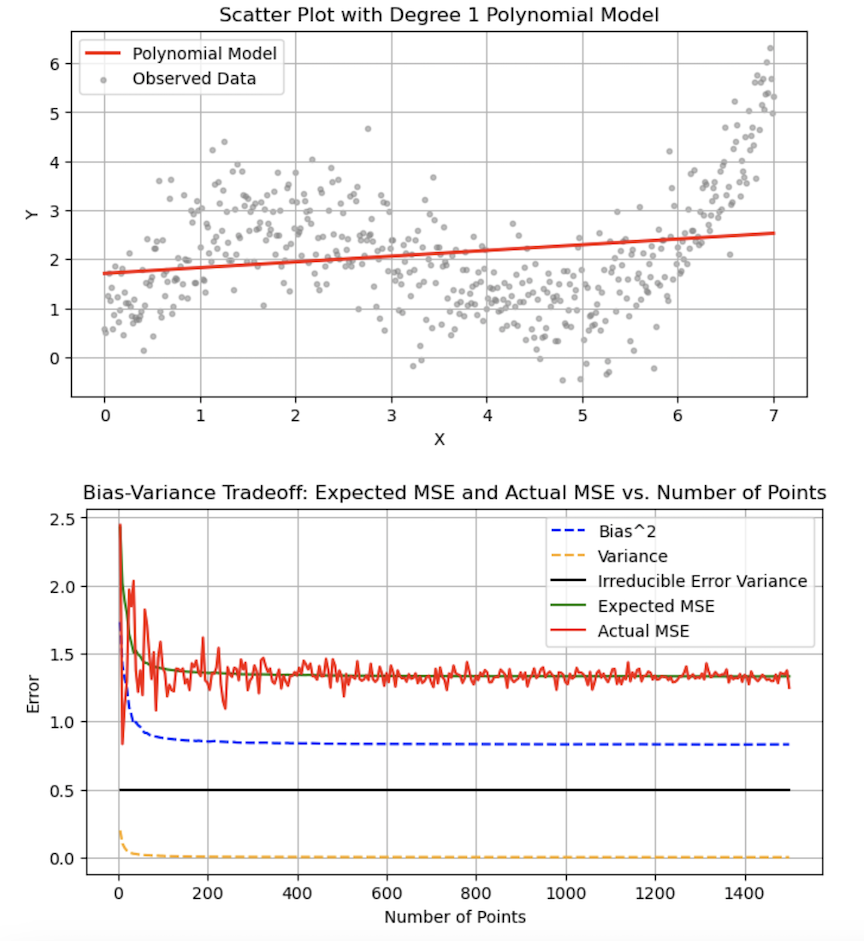

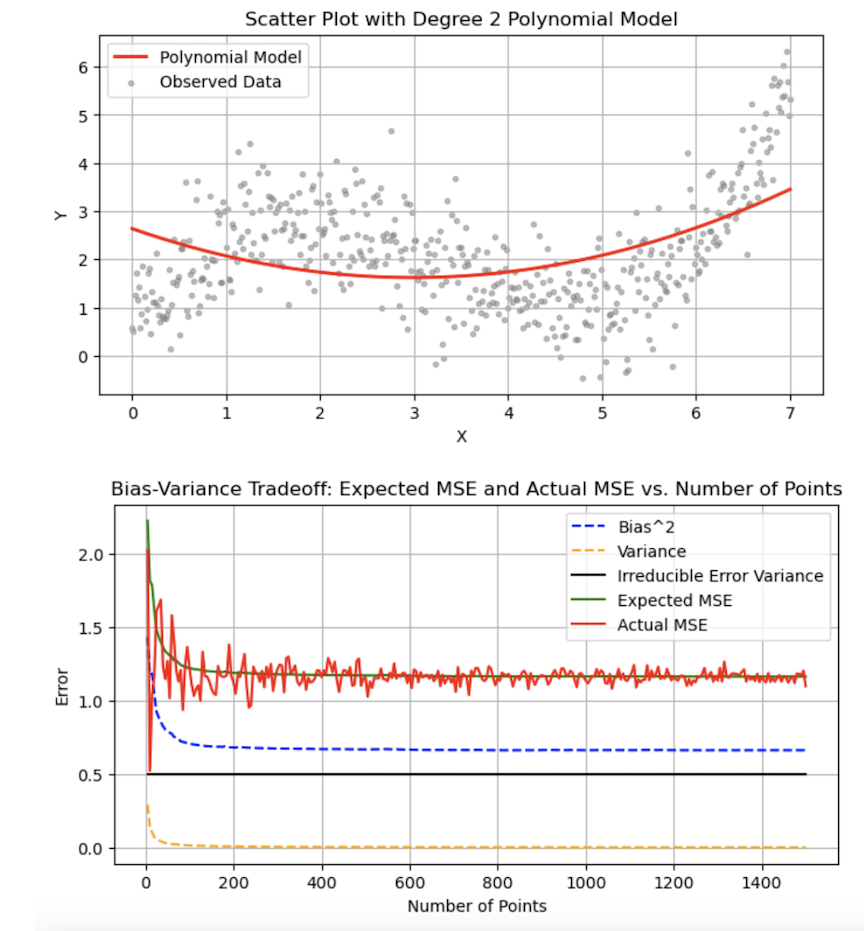

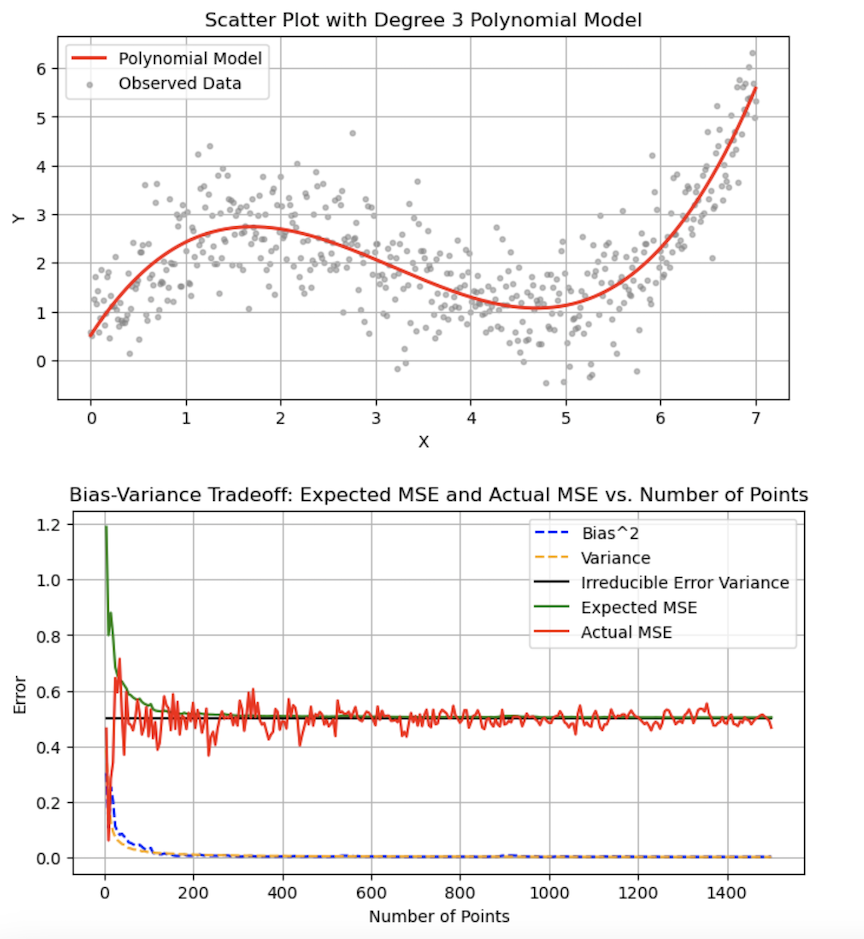

### Underfitting and Overfitting the Data Set: Which is the Right Model?

In this last example, we'll generate a series of polynomial models of increasing degree 
and look at the MSE.  

The most important question is: **Which is the right model?**

(We'll consider more sophisticated testing methods next week!)

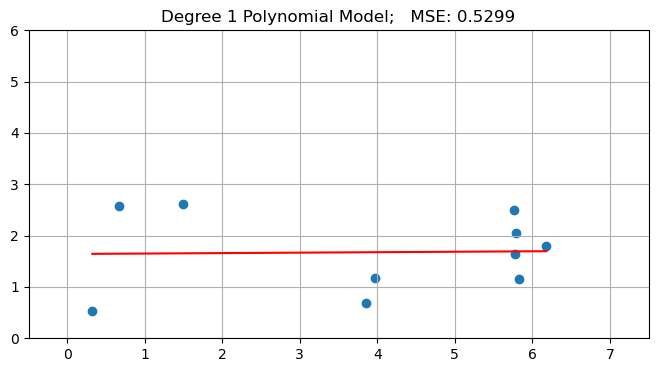

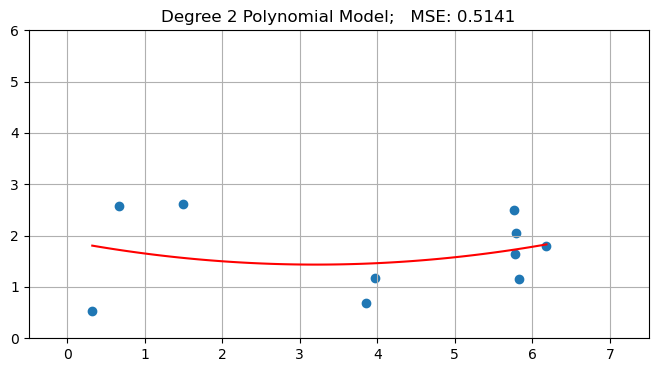

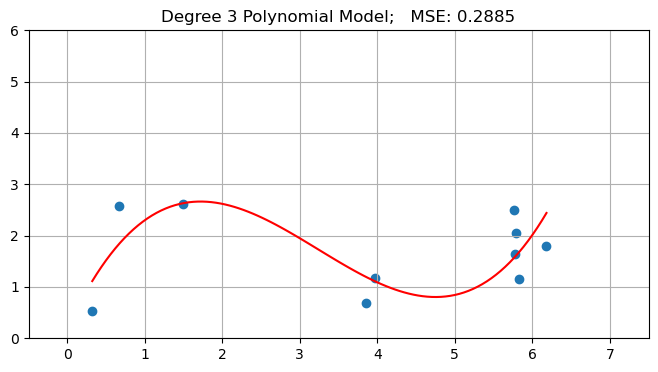

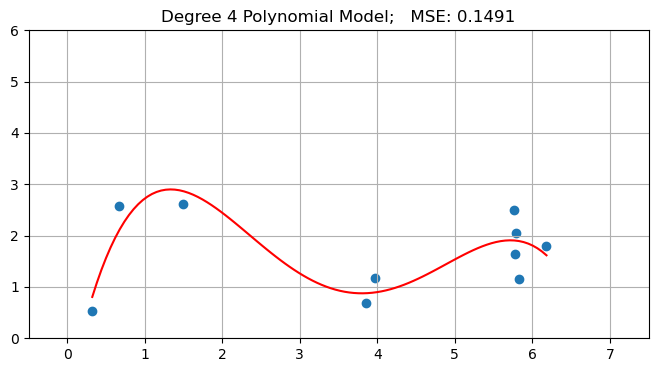

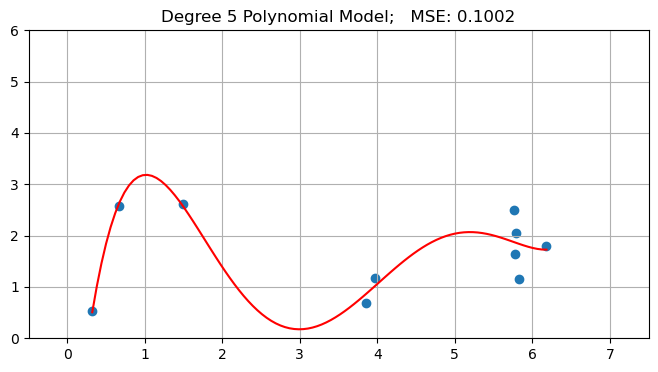

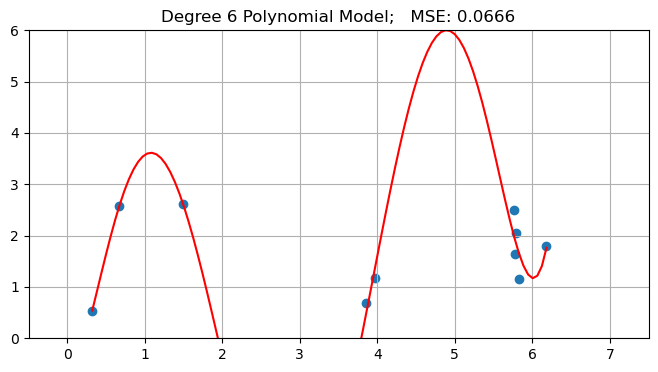

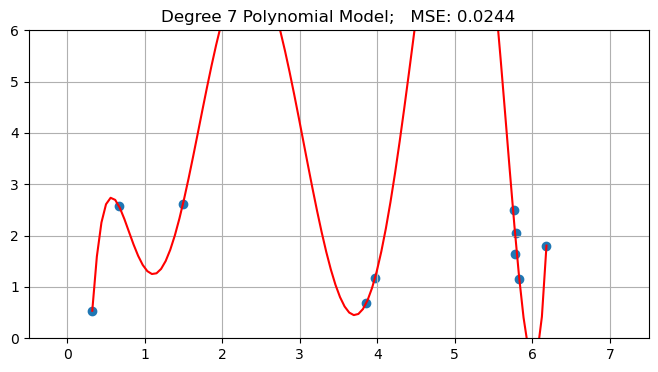

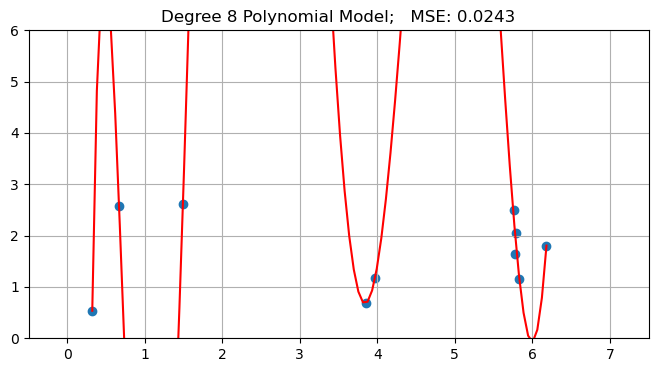

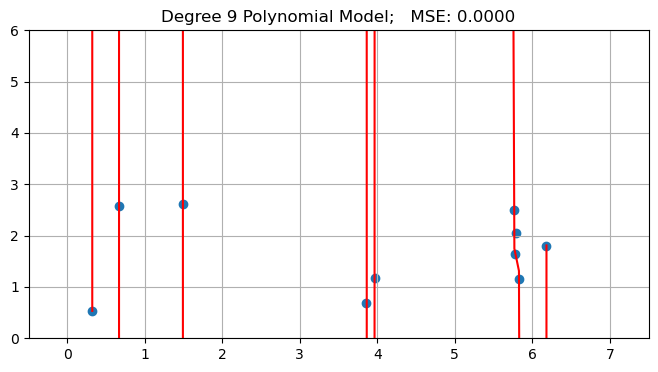

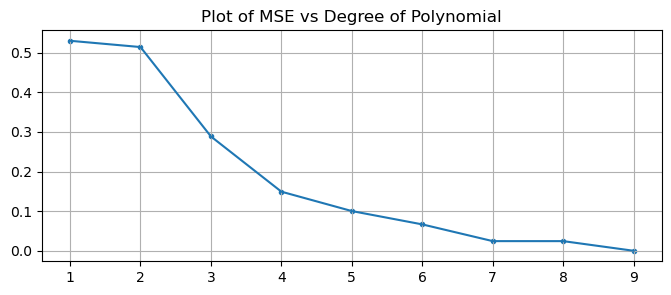

In [9]:
# Final example

size = 10
degree = 1
error_std = 0.5

# dataset
Xs = np.sort(np.random.uniform(low=lb, high=ub, size=size))
Y = f(Xs) + np.random.normal(0, error_std,size=size)

def do_final_example(Xs,Y):

    mses = []
    r2s = []

    for D in range(1,size):

        X_reshaped = Xs.reshape(-1, 1)
        model = make_pipeline(PolynomialFeatures(D), LinearRegression())
        model.fit(X_reshaped, Y)
        Y_hat = model.predict(X_reshaped)



        # Mean Squared Error (MSE)
        mse = mean_squared_error(Y,Y_hat)

        # R^2
        ss_residual = np.sum((Y - Y_hat)**2)  # Sum of squared residuals
        ss_total = np.sum((Y - np.mean(Y))**2)  # Total sum of squares
        r_squared = 1 - (ss_residual / ss_total)


        # Plot the results
        plt.figure(figsize=(8,4))
        plt.title(f"Degree {D} Polynomial Model;   MSE: {mse:.4f}")

        Xss = np.linspace(min(Xs),max(Xs),100)
        Yss = model.predict(Xss.reshape(-1,1))
    #     plt.xlim([0,7])
    #     plt.ylim([min(min(Yss),0),max(max(Yss),6)])
        plt.xlim([-0.5,7.5])
        plt.ylim([0,6])
        plt.scatter(Xs, Y)
        plt.plot(Xss,Yss,color='r')
    #     plt.plot(Xss,Yss,color='r',linestyle='--')
    #     plt.scatter(Xs, Y_hat,color='r',marker='x')
        plt.grid()
        plt.show()
    #     print(f'MSE: {mse:.4f}')
    #     print(f'R^2: {r_squared:.4f}')

        mses.append(mse)
        r2s.append(r_squared)

    plt.figure(figsize=(8,3))
    plt.title("Plot of MSE vs Degree of Polynomial")
    plt.plot(range(1,size),mses)
    plt.scatter(range(1,size),mses,marker='.')
    plt.grid()
    plt.show()

do_final_example(Xs,Y)

### Your Turn!

Run the last cell multiple times. Since we did not set a random state to keep the results the same every time,
you'll see a different data set each time. 

## Appendix A: Understanding the Bias-Variance Decomposition (Optional)

Bias-Variance is presented as a fundamental analysis tool in Section 2.2.2 of ISL. On page 32 the following formula appears which explains precisely the components of the mean square error.  Intuition is given, but not many details about how this formula arises. 

$$
\mathbb{E}\left[(y_0 - \hat{f}(x_0))^2\right] 
      = \underbrace{\underbrace{\big(f(x_0) - \mathbb{E}[\hat{f}(x_0)]\big)^2}_{\text{Bias}^2} 
      + \underbrace{\text{Var}(\hat{f}(x_0))}_{\text{Variance}}}_{\text{Reducible Error}}
      + \underbrace{\text{Var}(\epsilon)}_{\text{Irreducible Error}}
$$
 

Each term reflects a specific source of error:

1. **Variance:** $\text{Var}(\hat{f}(x_0))= \mathbb{E}[(\mathbb{E}[\hat{f}(x_0)] - \hat{f}(x_0))^2]$
   - Measures how much the model’s predictions vary when trained on different **training datasets.**
   - High variance indicates the model is overly sensitive to the training data, leading to overfitting.

2. **Squared Bias:** ($\text{Bias}(\hat{f}(x_0)))^2=(f(x_0) - \mathbb{E}[\hat{f}(x_0)])^2$:
   - Bias measures how far the model’s average prediction is from the true value.
   - High bias indicates the model is too simplistic, leading to underfitting.

3. **Irreducible Error:** $\text{Var}(\epsilon)$
   - Represents noise in the data that no model can remove, such as random errors or unmeasured factors.



#### What? Variance is an MSE?

<blockquote>
    
At first sight, the formula seems odd (at least it did to me): the MSE is decomposed into variances.  However, the variance of a list of values is actually a type of MSE!

Our definition of MSE from Week 2 is: 

$$\text{MSE} = \frac{e^2_1 + e^2_2 + \cdots + e^2_n}{n} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2. $$

The variance of a list of values $Z = z_1, \ldots, z_n$ is defined as

$$ \text{Var}(Z)\ =\ \frac{1}{n} \sum_{i=1}^n (\mathbb{E}(Z) - z_i)^2. $$

Thus, $\text{Var}(Z)$ is the MSE between $Z$ and the list of $n$ values $[\mathbb{E}(Z), \mathbb{E}(Z), \ldots, \mathbb{E}(Z)].$
</blockquote>

---


### **Breaking Down the Formula**

Let’s now derive the formula step by step.

Since $y_0 = f(x_0) + \epsilon$, the error for a single prediction is:


$$\begin{aligned}
        y_0 - \hat{f}(x_0) &= f(x_0) + \epsilon - \hat{f}(x_0)            \\       
                 &= \big(f(x_0) - \hat{f}(x_0)\big) + \epsilon   \\
  \end{aligned}$$
  


Taking the square and expectation on both sides:

$$\begin{aligned}
\mathbb{E}\left[(y_0 - \hat{f}(x_0))^2\right] &= \mathbb{E}\left[\big((f(x_0) - \hat{f}(x_0)) + \epsilon\big)^2\right]\\
&= \mathbb{E}\big[(f(x_0) - \hat{f}(x_0))^2 +  2(f(x_0) - \hat{f}(x_0))\epsilon + \epsilon^2\big]\\
&= \mathbb{E}\left[(f(x_0) - \hat{f}(x_0))^2\right] +  \mathbb{E}\left[2(f(x_0) - \hat{f}(x_0))\epsilon\right] + \mathbb{E}[\epsilon^2].
\end{aligned}$$




Because $\epsilon$ and $(f(x_0) - \hat{f}(x_0))$ are independent and we assume $\mathbb{E}(\epsilon)=0$, 

$$
\mathbb{E}\left[2(f(x_0) - \hat{f}(x_0))\epsilon\right]
      \  =\  2\mathbb{E}\left[(f(x_0) - \hat{f}(x_0))\right] \cdot \mathbb{E}\left[\epsilon\right]\ =\ 0.$$


The last term is easily converted into the appropriate variance:

$$\mathbb{E}[\epsilon^2]\ =\ \mathbb{E}[(\mathbb{E}(\epsilon)-\epsilon)^2]\ =\ Var(\epsilon).$$

Now the term $(f(x_0) - \hat{f}(x_0))^2$ represents the squared errors introduced by the model and we need to decompose it into bias and variance. Let's introduce the term $\mathbb{E}[\hat{f}(x_0)]$ inside the square, introduce some useful abbreviations, and multiply it out:


$$\begin{aligned}
        (f(x_0) - \hat{f}(x_0))^2 &= \bigl(f(x_0) - \mathbb{E}[\hat{f}(x_0)] + \mathbb{E}[\hat{f}(x_0)] - \hat{f}(x_0)\bigr)^2         \\       
                 &= \bigl(\underbrace{(f(x_0) - \mathbb{E}[\hat{f}(x_0)])}_{\text{b}} - \underbrace{(\hat{f}(x_0) - \mathbb{E}[\hat{f}(x_0)])}_{\delta}\bigr)^2  \\
                 &= (b - \delta)^2\\
                 &= b^2 - 2b\delta+\delta^2\\
\end{aligned}$$
    
Taking the expectation $\mathbb{E}[\cdot]$ on both sides:    
    
$$\begin{aligned}
        \mathbb{E}\left[(f(x_0) - \hat{f}(x_0))^2\right] 
        &= \mathbb{E}[(b - \delta)^2]\\
        &= \mathbb{E}[b^2 - 2b\delta+\delta^2]\\
        &= b^2 - 2b\mathbb{E}[\delta]+\mathbb{E}[\delta^2],\\
\end{aligned}$$
using the fact that $b$ is a constant, since
both $f(x_0)$ and $\mathbb{E}(\hat{f}(x_0))$ are constants.
    
</blockquote>


Since $\delta = \hat{f}(x_0) - \mathbb{E}[\hat{f}(x_0)]$, its expectation is zero:

$$\begin{aligned}
\mathbb{E}[\delta] &= \mathbb{E}[\hat{f}(x_0) - \mathbb{E}[\hat{f}(x_0)]] \\
&= \mathbb{E}[\hat{f}(x_0)] - \mathbb{E}[\mathbb{E}(\hat{f}(x_0))] \\
&= \mathbb{E}[\hat{f}(x_0)] - \mathbb{E}[\hat{f}(x_0)] \\
&= 0, \\
\end{aligned}
$$

and $\mathbb{E}[\delta^2]$ is the variance of $\hat{f}(x_0)$:

$$\begin{aligned}
\mathbb{E}[\delta^2] &= \mathbb{E}[(\hat{f}(x_0) - \mathbb{E}[\hat{f}(x_0)])^2] \\
&= \mathbb{E}[(\mathbb{E}[\hat{f}(x_0)-\hat{f}(x_0)])^2]\\
&= \mathrm{Var}(\hat{f}(x_0)).\\
\end{aligned}$$


Thus:

$$\begin{aligned}
\mathbb{E}[(f(x_0) - \hat{f}(x_0))^2] &= b^2 + \mathrm{Var}(\hat{f}(x_0))\\
&= (f(x_0) - \mathbb{E}[\hat{f}(x_0)])^2 + \mathrm{Var}(\hat{f}(x_0)).\\
\end{aligned}$$

---

### The Final Formula

Combining these results, the decomposition becomes:

$$
\mathbb{E}\left[(y_0 - \hat{f}(x_0))^2\right] 
      = \underbrace{\underbrace{\big(f(x_0) - \mathbb{E}[\hat{f}(x_0)]\big)^2}_{\text{Bias}^2} 
      + \underbrace{\text{Var}(\hat{f}(x_0))}_{\text{Variance}}}_{\text{Reducible Error}}
      + \underbrace{\text{Var}(\epsilon)}_{\text{Irreducible Error}}
$$


